In [286]:
# Import Dependencies.
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [287]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

In [288]:
# --- 1. Data Loading and Preprocessing ---

# Load S&P 500 data, handle encoding errors if neededtry:
try:
    gspc_df = pd.read_csv('gspc_daily_price.csv', parse_dates=['Date'], encoding='latin1')
except UnicodeDecodeError:
    gspc_df = pd.read_csv('gspc_daily_price.csv', parse_dates=['Date'], encoding='cp1252')

# Load VIX (volatility index) and sentiment data
vix_df = pd.read_csv('vix_daily_price.csv', parse_dates=['Date'])
sentiment_df = pd.read_csv('news_sentiment_data.csv', parse_dates=['date'])

C:\Users\mehdi\AppData\Local\Temp\ipykernel_13492\2070514037.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gspc_df = pd.read_csv('gspc_daily_price.csv', parse_dates=['Date'], encoding='latin1')
C:\Users\mehdi\AppData\Local\Temp\ipykernel_13492\2070514037.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  vix_df = pd.read_csv('vix_daily_price.csv', parse_dates=['Date'])


In [289]:
# Clean column names to remove extra spaces and fix misnamed columns
# This ensures compatibility with further data processing
gspc_df.rename(columns={'Close ': 'Close', 'Open ': 'Open', 'High ': 'High', 'Low ': 'Low', 'Volume ': 'Volume'}, inplace=True)
vix_df.rename(columns={'Close ': 'Close', 'Open ': 'Open', 'High ': 'High', 'Low ': 'Low'}, inplace=True)
sentiment_df.rename(columns={'date': 'Date'}, inplace=True)

In [290]:
# Sort data by date to ensure proper chronological order for time series analysis
gspc_df.sort_values(by='Date', inplace=True)
vix_df.sort_values(by='Date', inplace=True)
sentiment_df.sort_values(by='Date', inplace=True)

In [291]:
# Merge datasets on 'Date' to combine S&P 500, VIX, and sentiment data
print("Merging Data...")
df = pd.merge(gspc_df, vix_df, on='Date', suffixes=('_sp500', '_vix'))
df = pd.merge(df, sentiment_df, on='Date', how='left')
df.fillna(0, inplace=True)

Merging Data...


In [292]:
# Check the column names
print(df.columns) 

Index(['Date', 'Open_sp500', 'High_sp500', 'Low_sp500', 'Close _sp500',
       'Volume', 'Open_vix', 'High_vix', 'Low_vix', 'Close _vix',
       'News Sentiment'],
      dtype='object')


In [293]:
# Remove any hidden characters like non-breaking spaces from column names
df.columns = df.columns.str.replace('\xa0', '')

In [294]:
# Verify the column names are now correct
print(df.columns) 

Index(['Date', 'Open_sp500', 'High_sp500', 'Low_sp500', 'Close_sp500',
       'Volume', 'Open_vix', 'High_vix', 'Low_vix', 'Close_vix',
       'News Sentiment'],
      dtype='object')


In [295]:
df.dtypes

Date              datetime64[ns]
Open_sp500               float64
High_sp500               float64
Low_sp500                float64
Close_sp500              float64
Volume                     int64
Open_vix                 float64
High_vix                 float64
Low_vix                  float64
Close_vix                float64
News Sentiment           float64
dtype: object

In [296]:
df

,Date,Open_sp500,High_sp500,Low_sp500,Close_sp500,Volume,Open_vix,High_vix,Low_vix,Close_vix,News Sentiment
0,2024-03-18,5154.77,5175.60,5145.47,5149.42,4036220000,14.75,14.85,14.26,14.33,0.17
1,2024-03-19,5139.09,5180.31,5131.59,5178.51,4031760000,14.50,14.86,13.80,13.82,0.17
2,2024-03-20,5181.69,5226.19,5171.55,5224.62,4064850000,13.83,14.17,13.01,13.04,0.17
3,2024-03-21,5253.43,5261.10,5240.66,5241.53,4207730000,12.98,13.08,12.40,12.92,0.17
4,2024-03-22,5242.48,5246.09,5229.87,5234.18,3374700000,12.92,13.15,12.58,13.06,0.16
...,...,...,...,...,...,...,...,...,...,...,...
245,2025-03-11,5603.65,5636.30,5528.41,5572.07,6221240000,27.94,29.57,26.18,26.92,-0.05
246,2025-03-12,5624.84,5642.19,5546.09,5599.30,5219830000,26.88,26.91,23.89,24.23,-0.07
247,2025-03-13,5594.45,5597.78,5504.65,5521.52,5018980000,24.92,26.13,23.46,24.66,-0.08
248,2025-03-14,5563.85,5645.27,5563.85,5638.94,4863180000,24.35,24.36,21.48,21.77,-0.09


In [297]:
# Calculate Relative Strength Index (RSI) for S&P 500 data
# RSI is a momentum indicator that measures the speed and change of price movements
def calculate_rsi(data, window=14):
    delta = data['Close_sp500'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df)
df['Close_sp500'] = pd.to_numeric(df['Close_sp500'], errors='coerce')
df.fillna(0, inplace=True)

In [298]:
df.tail()

,Date,Open_sp500,High_sp500,Low_sp500,Close_sp500,Volume,Open_vix,High_vix,Low_vix,Close_vix,News Sentiment,RSI_14
245,2025-03-11,5603.65,5636.30,5528.41,5572.07,6221240000,27.94,29.57,26.18,26.92,-0.05,19.949994
246,2025-03-12,5624.84,5642.19,5546.09,5599.30,5219830000,26.88,26.91,23.89,24.23,-0.07,22.796279
247,2025-03-13,5594.45,5597.78,5504.65,5521.52,5018980000,24.92,26.13,23.46,24.66,-0.08,23.451456
248,2025-03-14,5563.85,5645.27,5563.85,5638.94,4863180000,24.35,24.36,21.48,21.77,-0.09,33.012305
249,2025-03-17,5635.60,5703.52,5631.12,5675.12,5031770000,22.89,22.95,20.32,20.51,-0.12,36.289509


In [299]:
# Prepare data for LSTM
# Make a copy so original dataframe is not altered.
merged_data = df.copy()

In [300]:
# Rename columns for better readability
merged_data.rename(columns={'Close_sp500': 'Close_SP500', 'Open_sp500': 'Open_SP500', 'High_sp500': 'High_SP500', 'Low_sp500': 'Low_SP500', 'Volume': 'Volume_SP500', 'RSI_14': 'RSI', 'Close_vix': 'Close_VIX', 'News Sentiment': 'News Sentiment'}, inplace=True)

In [301]:
# Load the scaler
scaler = joblib.load('scaler.pkl')
data_scaled = scaler.transform(merged_data[['Close_SP500', 'Open_SP500', 'High_SP500', 'Low_SP500', 'Volume_SP500', 'RSI', 'Close_VIX', 'News Sentiment']])

In [302]:
# Scale data using MinMaxScaler to normalize values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(merged_data[['Close_SP500', 'Open_SP500', 'High_SP500', 'Low_SP500', 'Volume_SP500', 'RSI', 'Close_VIX', 'News Sentiment']])

In [303]:
# Create datasets for LSTM training with a look-back period
def create_dataset(data, look_back=30):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

In [304]:
# Generate training data with a 30-day look-back period
look_back = 30
X, y = create_dataset(data_scaled, look_back)

In [305]:
# Split data into training and testing sets, keeping chronological order for time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [306]:
# Reshape data for LSTM input: [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [307]:
# Build LSTM model with dropout and L2 regularization to prevent overfitting
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(look_back, X_train.shape[2]), kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation=LeakyReLU(), kernel_regularizer=l2(0.001)), # Changed activation function
    Dense(1)
])

C:\Users\mehdi\anaconda3\envs\dev\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [308]:
# Adam optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.0005) 

In [309]:
# Compile model
model.compile(optimizer=optimizer, loss='mean_absolute_error')

In [310]:
# Apply early stopping to monitor validation loss and prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Increased patience.

In [311]:
# Train the model using the training data
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.5634 - val_loss: 0.3671
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3720 - val_loss: 0.4223
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3469 - val_loss: 0.3199
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3237 - val_loss: 0.3125
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3070 - val_loss: 0.3162
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2933 - val_loss: 0.3003
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2909 - val_loss: 0.2979
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2763 - val_loss: 0.2949
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2667 - val_loss: 0.2899
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2706 - val_loss: 0.2876
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2625 - val_loss: 0.2758
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2500 - val_lo

In [312]:
# Predict stock prices using the trained model
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


In [313]:
# Inverse transform predictions and actual values to original scale
y_test_inv = scaler.inverse_transform(np.column_stack([y_test] + [np.zeros(y_test.shape)] * (X_test.shape[2] - 1)))[:, 0]
y_pred_inv = scaler.inverse_transform(np.column_stack([y_pred.flatten()] + [np.zeros(y_pred.shape)] * (X_test.shape[2] - 1)))[:, 0]

In [314]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Absolute Error (MAE): 54.37
Mean Squared Error (MSE): 4681.00
R^2 Score: 0.83


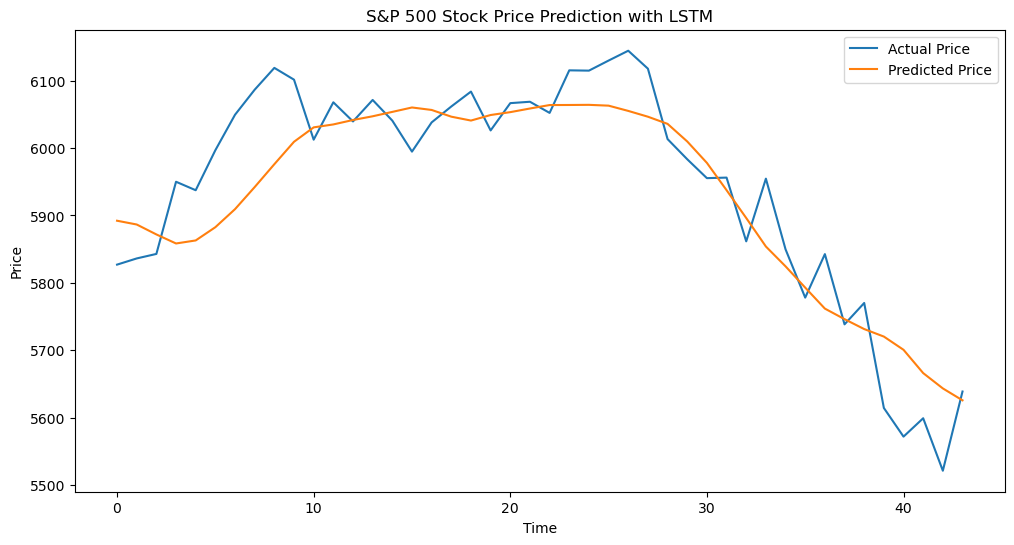

In [315]:
# Plot actual vs predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(y_pred_inv, label='Predicted Price')
plt.legend()
plt.title('S&P 500 Stock Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

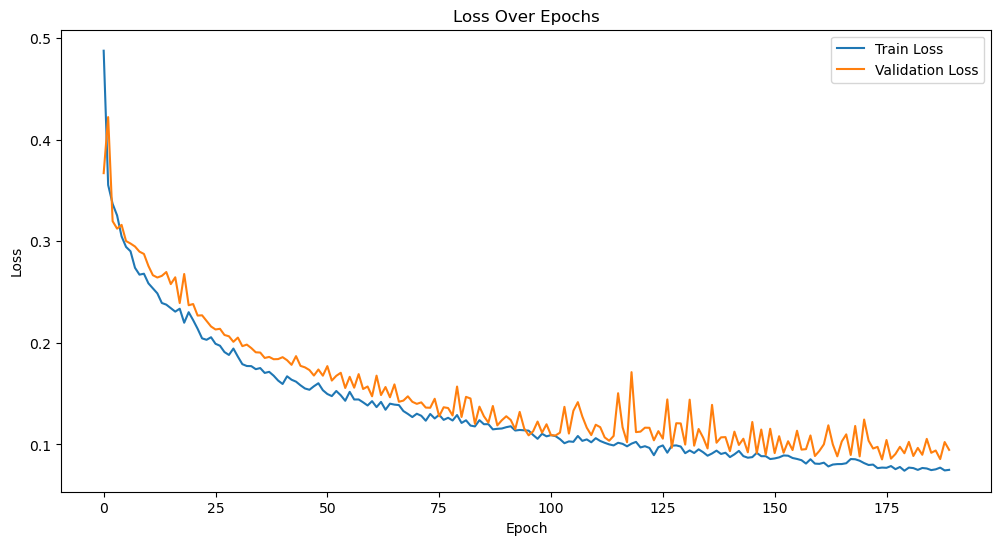

In [316]:
# Plot training and validation loss to check for overfitting or underfitting
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()